In [1]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import ks_2samp

In [2]:
def get_data(split: str):
    df = pd.read_csv(f'diamonds_{split}.csv')
    df = df.rename(columns = {'Unnamed: 0': 'Index'})
    # print(df.dtypes)
    x = df.drop(['Index', 'price'], axis = 1) # index col not needed
    # print(x.describe())
    y = df['price']
    # print(y.describe())
    # x_arr = x.to_numpy()
    # y_arr = y.to_numpy()
    # # print(x_arr[1])
    # print(y_arr[0])
    return x, y

In [10]:
def ohe(df, col: str):
  visited = []
  for val in df[col]:
    if val not in visited:
      visited.append(val)
  for val in visited:
    if f'{val}_{col}' not in df.columns:
      df[f'{val}_{col}'] = df[col].apply(lambda x: 1 if x == val else 0)

  df = df.drop(col, axis = 1)
  return df

In [3]:
def feature_engineering(split):
  x_train, y_train = get_data('train')
  x_train = ohe(x_train, 'color')
  x_train = ohe(x_train, 'cut')
  x_train = ohe(x_train, 'clarity')

  if split != "train":
    ks= {}

    x_split, y_split = get_data(split)
    x_split = ohe(x_split, 'color')
    x_split = ohe(x_split, 'cut')
    x_split = ohe(x_split, 'clarity')
    train = pd.concat([x_train, y_train], axis = 1)
    val = pd.concat([x_split, y_split], axis = 1)
    for col in train.columns:
      stat, p = ks_2samp(train[col], val[col])
      ks[col] = f'statistic: {stat}', f'p-value: {p}'
  else:
    x_split, y_split = x_train, y_train

  for k, v in ks.items():
    _, p = v
    p = float(p.split(': ')[1])
    if p < 0.05:
      print('different distributions')
      raise Exception

  print('p looks good')
  scaler = StandardScaler()
  scaler.fit(y_train.to_numpy().reshape(-1, 1))
  y_split = scaler.transform(y_split.to_numpy().reshape(-1, 1))
  n_feats = x_split.shape[1]
  # print(n_feats)
  x_split = x_split.to_numpy()
  return x_split, y_split, n_feats, ks

# change param to use train as a basis for fit


In [ ]:
feature_engineering('val')

p looks good


(array([[ 0.29, 62.8 , 44.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.3 , 63.5 , 55.  , ...,  0.  ,  0.  ,  0.  ],
        [ 1.01, 62.  , 57.  , ...,  0.  ,  0.  ,  0.  ],
        ...,
        [ 0.3 , 61.8 , 55.  , ...,  0.  ,  0.  ,  0.  ],
        [ 1.16, 61.2 , 58.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.34, 62.9 , 55.  , ...,  0.  ,  0.  ,  0.  ]]),
 array([[-0.86791129],
        [-0.76189848],
        [ 0.33096516],
        ...,
        [-0.81780072],
        [ 1.59153552],
        [-0.81452717]]),
 26,
 {'carat': ('statistic: 0.010729514275120478', 'p-value: 0.6349713469900817'),
  'depth': ('statistic: 0.013116425658138642', 'p-value: 0.3781841010821523'),
  'table': ('statistic: 0.00426399703374114', 'p-value: 0.9999924703974541'),
  'x': ('statistic: 0.01068316648127543', 'p-value: 0.6403816964081891'),
  'y': ('statistic: 0.009709862810530212', 'p-value: 0.7527413041865041'),
  'z': ('statistic: 0.011123470522803103', 'p-value: 0.5892139525783757'),
  'F_color': ('statistic:

In [4]:
def relu(z: np.ndarray):
    return np.maximum(0, z)

def sigmoid(z: np.ndarray):
    return 1 / (1 + np.exp(-z))

def tanh(z: np.ndarray | int | float):
    res = ((np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z)))
    assert np.abs(res - np.tanh(z)) <= 1e-5
    return res

def half_mse(yhat, y, W: list[np.ndarray], alpha):
    y = y.reshape(-1, 1)
    yhat = yhat.reshape(-1, 1)

    loss = 0.5 * np.mean((y - yhat) ** 2)
    reg = (alpha/2)
    reg_param = 0
    for w in W:
        reg_param += (np.sum(w ** 2))
    reg *= reg_param
    return loss + reg

def forward_prop(x, y, W: list[np.ndarray], b: list[np.ndarray], alpha, act_fn):
    if len(W) != len(b):
        print('unequal amount of weights and biases')
        return None

    if len(x.shape) == 1:
        x = x.reshape(1, -1) # if theres 1 sample

    x_col = x.T
    # print(f'x col shape: {x_col.shape}')
    # print(f'w[0] shape: {W[0].shape}')

    z = {}
    h = {}

    z[0] = W[0] @ x_col + b[0][:, np.newaxis]
    h[0] = act_fn(z[0])

    for w in range(1, len(W)):
        # print(f'Weight at index {w}: {W[w].shape}')
        # print(f'activation at index {w-1}: {h[w-1].shape}')
        # print(f'bias at index {w}: {b[w].shape}')

        z[w] = W[w] @ h[w-1] + b[w][:, np.newaxis]

        if w < len(W) - 1 or act_fn == sigmoid:
            h[w] = act_fn(z[w])
        else:
            h[w] = z[w]

    # for k, v in z.items():
        # print(f'z layer {k}: {v.shape}')
    # for k, v in h.items():
        # print(f'h layer {k}: {v.shape}')

    y_hat = h[len(W) - 1] if len(W) - 1 in h else z[len(W) - 1]
    # print(f'y_hat shape: {y_hat.shape}')

    if len(y.shape) == 1:
        y = y.reshape(-1, 1)

    loss = half_mse(y_hat, y, W, alpha)

    return loss, z, h, x, y_hat

def back_prop(X, y, W: list[np.ndarray], B: list[np.ndarray], alpha, act_fn):
    if len(X.shape) == 1:
        X = X.reshape(1, -1)
    loss, z, h, x, yhat = forward_prop(X, y, W, B, alpha, act_fn)

    if len(y.shape) == 1:
        y = y.reshape(-1, 1)
    dW = []
    dB = []
    n_layers = len(W)

    delta = None
    for i in range(n_layers - 1, -1, -1):

        if i == n_layers - 1:
            delta = -(y - yhat.T).T
        else:
            if act_fn == relu:
                delta = (W[i+1].T @ delta) * (z[i] > 0)
            elif act_fn == sigmoid:
                delta = (W[i+1].T @ delta) * (h[i] * (1 - h[i]))
            elif act_fn == tanh:
                delta = (W[i+1].T @ delta) * (1 - h[i]**2)
            else:
                print('Unsupported activation function')
                return None

        if i > 0:
            dW_i = delta @ h[i-1].T / X.shape[0]
        else:
            dW_i = delta @ X / X.shape[0]

        dB_i = np.mean(delta, axis=1)

        dW_i = dW_i + alpha * W[i]

        dW.insert(0, dW_i)
        dB.insert(0, dB_i)

    return dW, dB, loss



def train(x_train: np.ndarray, y_train: np.ndarray, x_val: np.ndarray, y_val: np.ndarray, W: list[np.ndarray], b: list[np.ndarray],
          learning_rate=1e-3, batch_size=32, num_epochs=100, reg_param=1e-4, clip_val=1.0, act_fn=relu, tol: float = 0.01, min_iter = 10):
    losses = []
    val_losses = []
    # print(f"Number of weight matrices: {len(W)}")

    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0
        idx = np.random.permutation(x_train.shape[0])
        x_train_shuffled, y_train_shuffled = x_train[idx], y_train[idx]

        for i in range(0, x_train.shape[0], batch_size):
            batch_x = x_train_shuffled[i:i+batch_size]
            batch_y = y_train_shuffled[i:i+batch_size]

            # print(f"Batch x shape: {batch_x.shape}")


            dW, dB, loss = back_prop(batch_x, batch_y, W, b, reg_param, act_fn)

            # print(f"Number of dW matrices: {len(dW)}")
            # print(f"Number of dB vectors: {len(dB)}")

            for j in range(len(W)):
                W[j] -= learning_rate * np.clip(dW[j], -clip_val, clip_val)
                b[j] -= learning_rate * np.clip(dB[j], -clip_val, clip_val)

            epoch_loss += loss

        avg_epoch_loss = epoch_loss / (x_train.shape[0] // batch_size + 1)
        losses.append(avg_epoch_loss)



        val_pred, _, _, _, _  = forward_prop(x_val, y_val, W, b, alpha = reg_param, act_fn = act_fn)
        val_losses.append(val_pred)

        n = len(y_val)

        print(f"\nEpoch {epoch+1}, Train Loss: {avg_epoch_loss:.4f}")



        print(f'\nhalf-mse performance on the validation data at Epoch {epoch + 1}: {val_losses[epoch]:.4f}')
        if np.abs(val_losses[epoch] - val_losses [epoch - 1]) < tol and epoch > min_iter:
          # print (f'{losses [epoch] - losses [epoch - 1]}')
          print(f"\nEpoch {epoch+1}, Train Loss: {losses[epoch]:.4f}")
          print(f'Stopped early because validation mse at current epoch {val_losses[epoch]:.4f} and validation mse at previous epoch {val_losses[epoch-1]:.4f} are too similar')

          aic_val = n * np.log(val_losses[epoch]) + 2 * n
          bic_val = n * np.log(val_losses[epoch]) + n * np.log(n)
          # print(f'Validation AIC at epoch{epoch + 1}:', aic_val)
          # print(f'Validation BIC at epoch{epoch + 1}:', bic_val)
          return losses, W, b

    # print(f'Validation AIC at epoch {epoch + 1}:', aic_val)
    # print(f'Validation BIC at epoch {epoch + 1}:', bic_val)

    return losses, W, b









# visual of arch

In [5]:
def create_computational_graph(W: list[np.ndarray], b: list[np.ndarray], act_fn) -> nx.DiGraph:
    n_layers = len(W)
    G = nx.DiGraph()
    activation_name = act_fn.__name__

    input_dim = W[0].shape[1]
    output_dim = W[-1].shape[0]

    G.add_node("X", label=f"Input\n(dim={input_dim}, or n_features)", pos=(0, 0), color="lightblue", shape="box")

    layer_width = 5
    node_height = 2


    for i in range(n_layers):
        w_y_pos = node_height * (i + 1)
        b_y_pos = -node_height * (i + 1)

        w_shape = W[i].shape
        G.add_node(f"W{i}",
                  label=f"W[{i}]\nShape: {w_shape}\nNorm: {np.linalg.norm(W[i]):.4f}",
                  pos=(i * layer_width + 0.5, w_y_pos),
                  color="orange")

        b_shape = b[i].shape
        G.add_node(f"b{i}",
                  label=f"b[{i}]\nShape: {b_shape}\nNorm: {np.linalg.norm(b[i]):.4f}",
                  pos=(i * layer_width + 0.5, b_y_pos),
                  color="lightgreen")

    for i in range(n_layers):
        layer_x_pos = (i + 1) * layer_width

        if i == 0:
            z_label = f"z[{i}] = W[{i}] @ X + b[{i}]"
            G.add_edge("X", f"z{i}", color="black")
        else:
            z_label = f"z[{i}] = W[{i}] @ h[{i-1}] + b[{i}]"
            G.add_edge(f"h{i-1}", f"z{i}", color="black")

        G.add_node(f"z{i}", label=z_label, pos=(layer_x_pos, 0), color="lightcoral")
        G.add_edge(f"W{i}", f"z{i}", color="black")
        G.add_edge(f"b{i}", f"z{i}", color="black")

        if i < n_layers - 1 or act_fn == sigmoid:
            h_label = f"h[{i}] = {activation_name}(z[{i}])"
            h_y_pos = -1
            G.add_node(f"h{i}", label=h_label, pos=(layer_x_pos, h_y_pos), color="yellow")
            G.add_edge(f"z{i}", f"h{i}", color="black")

    output_x = (n_layers + 1) * layer_width

    G.add_node("output",
              label=f"Output\n(dim={output_dim})",
              pos=(output_x, 0),
              color="lightblue",
              shape="box")


    ed = ([e for e in G.edges])
    G.add_edge(ed[-1][1], 'output', color = 'black')

    return G

def visualize_network(W: list[np.ndarray], b: list[np.ndarray], act_fn,
                      title: str = "Neural Network Architecture",
                      filename: str = "arch.png"):
    G = create_computational_graph(W, b, act_fn)
    title += f' With {act_fn.__name__} Activation Function'


    fig_width = 3 + len(W) * 3
    fig_height = 8
    plt.figure(figsize=(fig_width, fig_height))
    pos = nx.get_node_attributes(G, 'pos')
    node_colors = [G.nodes[n].get('color', 'lightgray') for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2500, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7, arrows=True, arrowsize=15)
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_weight='bold')

    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
if __name__ == "__main__":
    x_train, y_train, n_feats, _= feature_engineering('train')
    x_val, y_val, _, _  =feature_engineering('val')

    n_hidden = 64
    n_out = 1

    W1 = np.random.randn(n_hidden, n_feats) * 0.01
    b1 = np.zeros(n_hidden)
    W2 = np.random.randn(n_hidden, n_hidden) * 0.01
    b2 = np.zeros(n_hidden)
    W3 = np.random.randn(n_out, n_hidden) * 0.01
    b3 = np.zeros(n_out)
    losses, W, B = train(x_train, y_train, x_val, y_val, [W1, W2, W3], [b1, b2, b3])
    print(f'final train loss: {losses[-1]:.4f}')


  1%|          | 1/100 [00:00<00:51,  1.93it/s]


Epoch 1, Train Loss: 0.5000

half-mse performance on the validation data at Epoch 1: 0.5236


  2%|▏         | 2/100 [00:01<00:52,  1.86it/s]


Epoch 2, Train Loss: 0.4996

half-mse performance on the validation data at Epoch 2: 0.5233


  3%|▎         | 3/100 [00:01<00:52,  1.83it/s]


Epoch 3, Train Loss: 0.4993

half-mse performance on the validation data at Epoch 3: 0.5228


  4%|▍         | 4/100 [00:02<00:51,  1.85it/s]


Epoch 4, Train Loss: 0.4988

half-mse performance on the validation data at Epoch 4: 0.5218


  5%|▌         | 5/100 [00:02<00:51,  1.84it/s]


Epoch 5, Train Loss: 0.4970

half-mse performance on the validation data at Epoch 5: 0.5193


  6%|▌         | 6/100 [00:03<00:50,  1.85it/s]


Epoch 6, Train Loss: 0.4925

half-mse performance on the validation data at Epoch 6: 0.5107


  7%|▋         | 7/100 [00:03<00:50,  1.83it/s]


Epoch 7, Train Loss: 0.4725

half-mse performance on the validation data at Epoch 7: 0.4660


  8%|▊         | 8/100 [00:04<00:49,  1.84it/s]


Epoch 8, Train Loss: 0.3383

half-mse performance on the validation data at Epoch 8: 0.1898


  9%|▉         | 9/100 [00:04<00:50,  1.82it/s]


Epoch 9, Train Loss: 0.1283

half-mse performance on the validation data at Epoch 9: 0.1170


 10%|█         | 10/100 [00:05<00:58,  1.54it/s]


Epoch 10, Train Loss: 0.1075

half-mse performance on the validation data at Epoch 10: 0.1358


 11%|█         | 11/100 [00:06<01:05,  1.37it/s]


Epoch 11, Train Loss: 0.1010

half-mse performance on the validation data at Epoch 11: 0.1038


 11%|█         | 11/100 [00:07<01:01,  1.44it/s]


Epoch 12, Train Loss: 0.0993

half-mse performance on the validation data at Epoch 12: 0.1078

Epoch 12, Train Loss: 0.0993
Stopped early because validation mse at current epoch 0.1078 and validation mse at previous epoch 0.1038 are too similar
final train loss: 0.09925555220432014


In [ ]:
# np.save('Weights.npy', W)
# np.save('Biases.npy', B)
for i in range(len(W)):
  np.save(f'Weights_{i+1}.npy', W[i])
for j in range(len(B)):
  np.save(f'Biases_{j+1}.npy', B[j])

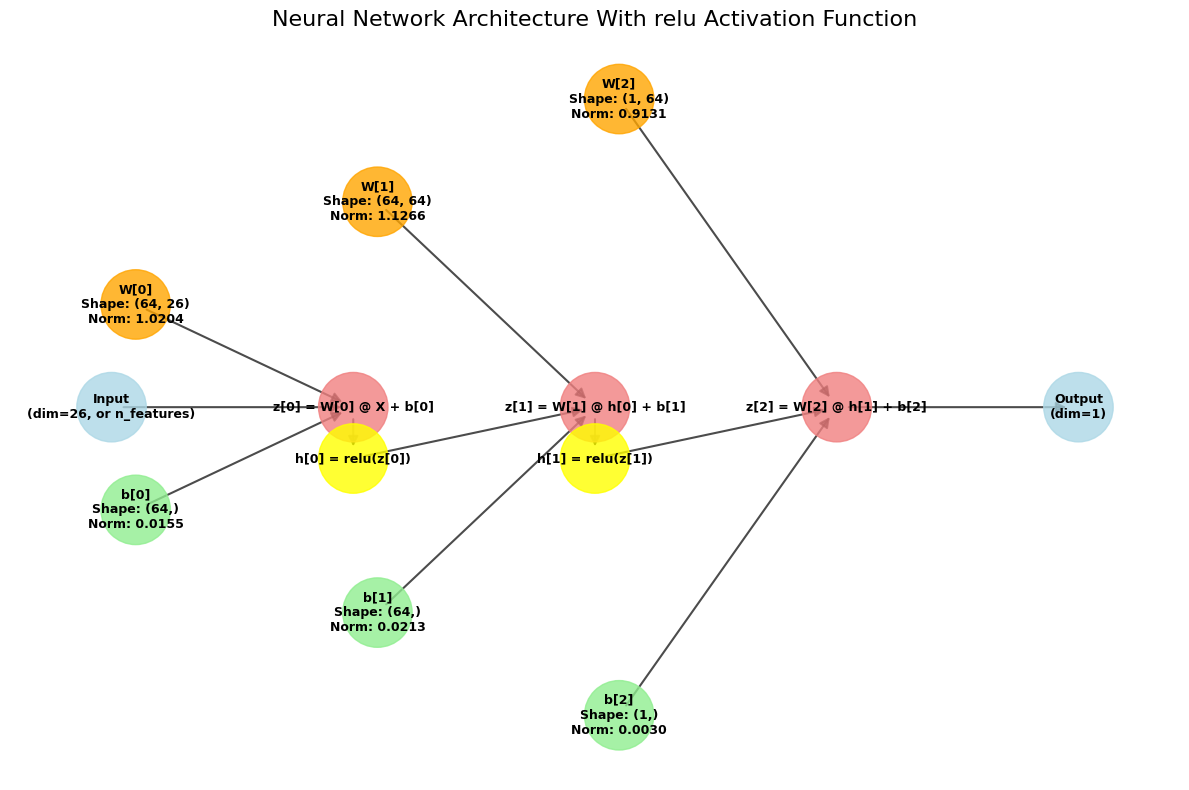

In [ ]:
visualize_network(W, B, relu)



In [ ]:
!ls

arch.png      diamonds_test.csv   state.npy	 Weights_3.npy
Biases_1.npy  diamonds_train.csv  state.txt	 Weights.npy
Biases_2.npy  diamonds_val.csv	  Weights_1.npy
Biases_3.npy  sample_data	  Weights_2.npy


In [ ]:
!zip -r stuff.zip .

  adding: .config/ (stored 0%)
  adding: .config/active_config (stored 0%)
  adding: .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: .config/config_sentinel (stored 0%)
  adding: .config/.last_update_check.json (deflated 23%)
  adding: .config/.last_opt_in_prompt.yaml (stored 0%)
  adding: .config/logs/ (stored 0%)
  adding: .config/logs/2025.04.22/ (stored 0%)
  adding: .config/logs/2025.04.22/13.37.36.419838.log (deflated 57%)
  adding: .config/logs/2025.04.22/13.37.37.101263.log (deflated 57%)
  adding: .config/logs/2025.04.22/13.37.16.947737.log (deflated 58%)
  adding: .config/logs/2025.04.22/13.36.56.098125.log (deflated 92%)
  adding: .config/logs/2025.04.22/13.37.26.087114.log (deflated 86%)
  adding: .config/logs/2025.04.22/13.37.27.297340.log (deflated 58%)
  adding: .config/gce (stored 0%)
  adding: .config/.last_survey_prompt.yaml (stored 0%)
  adding: .config/default_configs.db (deflated 98%)
  adding: .config/configurations/

# TEST TO COME ...

In [6]:
w1, w2, w3 = np.load('Weights_1.npy'), np.load('Weights_2.npy'), np.load('Weights_3.npy')
b1, b2, b3 = np.load('Biases_1.npy'), np.load('Biases_2.npy'), np.load('Biases_3.npy')
w = [w1, w2, w3]
b = [b1, b2, b3]


In [29]:
x_test, y_test, n_test, test_ks= feature_engineering('test')
x_val, y_val, n_val, _ = feature_engineering('val')

p looks good
p looks good


In [21]:
test_ks

{'carat': ('statistic: 0.008991472005932533', 'p-value: 0.829539974359703'),
 'depth': ('statistic: 0.009524471635150134', 'p-value: 0.773325354015395'),
 'table': ('statistic: 0.0102196885428254', 'p-value: 0.6944264630158914'),
 'x': ('statistic: 0.009709862810530212', 'p-value: 0.7527413041865041'),
 'y': ('statistic: 0.010451427512050415', 'p-value: 0.667445358444184'),
 'z': ('statistic: 0.0078791249536522', 'p-value: 0.9248314478543839'),
 'F_color': ('statistic: 0.002479606970708259', 'p-value: 1.0'),
 'H_color': ('statistic: 0.012676121616611025', 'p-value: 0.420688337048415'),
 'G_color': ('statistic: 0.007786429365962189', 'p-value: 0.9310388699601333'),
 'D_color': ('statistic: 0.010196514645902877', 'p-value: 0.697114381751474'),
 'E_color': ('statistic: 0.0008110863922877742', 'p-value: 1.0'),
 'I_color': ('statistic: 0.00451890989988879', 'p-value: 0.9999676268587002'),
 'J_color': ('statistic: 0.0024564330737857354', 'p-value: 1.0'),
 'Ideal_cut': ('statistic: 0.00560808

In [42]:
val_pred, _, _, _, y_hat_val= forward_prop(x_val, y_val, w, b, 1e-4, relu)
test_pred, _, _, _, y_hat_test= forward_prop(x_test, y_test, w, b, 1e-4, relu)
print(f'Half-MSE performance on validation set:  {val_pred:.6f}')

print(f'Half-MSE performance on test set:  {test_pred:.6f}')

Half-MSE performance on validation set:  0.108339
Half-MSE performance on test set:  0.107996


In [47]:
from sklearn.metrics import r2_score
y_hat_val.T.shape
y_val.shape
print(f'Validation R2: {r2_score(y_hat_val.T, y_val):.6f}')

print(f'Testing R2: {r2_score(y_hat_test.T, y_test):6f}')

Validation R2: 0.733817
Testing R2: 0.730929
